# RNN (Time Series)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

plt.rcParams["figure.figsize"] = (10,6)

sns.set_style("whitegrid")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Set it None to display all rows in the dataframe
# pd.set_option('display.max_rows', None)

# Set it to None to display all columns in the dataframe
pd.set_option('display.max_columns', None)

## Data

Release: Advance Monthly Sales for Retail and Food Services  
Units:  Millions of Dollars, Not Seasonally Adjusted

Frequency:  Monthly

The value for the most recent month is an advance estimate that is based on data from a subsample of firms from the larger Monthly Retail Trade Survey. The advance estimate will be superseded in following months by revised estimates derived from the larger Monthly Retail Trade Survey. The associated series from the Monthly Retail Trade Survey is available at https://fred.stlouisfed.org/series/MRTSSM448USN

Information about the Advance Monthly Retail Sales Survey can be found on the Census website at https://www.census.gov/retail/marts/about_the_surveys.html

Suggested Citation:
U.S. Census Bureau, Advance Retail Sales: Clothing and Clothing Accessory Stores [RSCCASN], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/RSCCASN, November 16, 2019.

https://fred.stlouisfed.org/series/RSCCASN

In [2]:
df = pd.read_csv('RSCCASN.csv',
                 index_col='DATE',
                 parse_dates=True
                ) 
# When working with time series we need to index date data (index_col='DATE',parse_dates=True)

In [3]:
df.head()

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 334 entries, 1992-01-01 to 2019-10-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   RSCCASN  334 non-null    int64
dtypes: int64(1)
memory usage: 5.2 KB


In [5]:
df.columns = ['Sales']

<AxesSubplot:xlabel='DATE'>

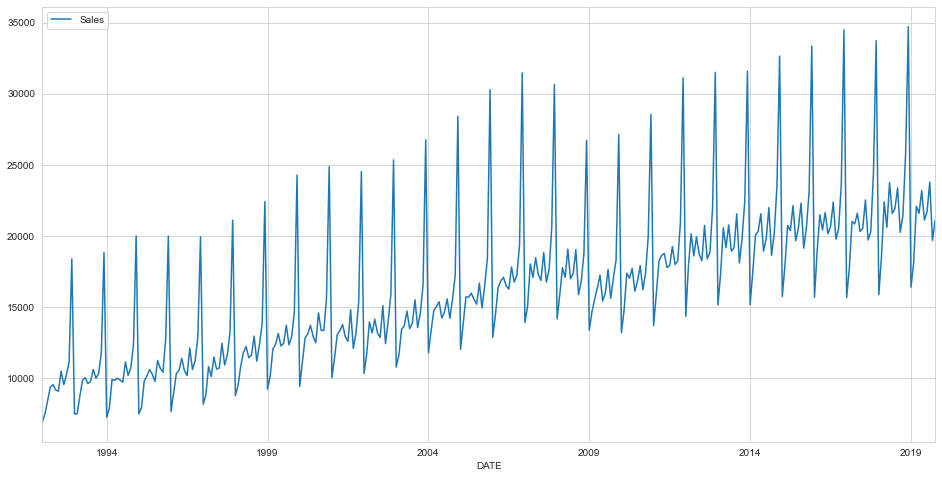

In [6]:
df.plot(figsize=(16,8))

## Preprocessing of Data

### Train Test Split

In [7]:
len(df) 
# Since there are data rows (monthly), the refresh period is every 12 rows (there is an annual change period)
# 12 observation also returns a cycle

334

In [8]:
test_size = 24 # set test_size: take longer than sequence(12) because val_loss is to follow

In [9]:
test_ind = len(df)- test_size # we set the index we will divide
test_ind

310

In [10]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [11]:
train

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2017-06-01,20322
2017-07-01,20535
2017-08-01,22536


In [12]:
test

,Sales
DATE,
2017-11-01,24438
2017-12-01,33720
2018-01-01,15881
2018-02-01,18585
2018-03-01,22404
2018-04-01,20616
2018-05-01,23764
2018-06-01,21589
2018-07-01,21919


### Scaling

In [13]:
from sklearn.preprocessing import MinMaxScaler

In [14]:
scaler = MinMaxScaler()

In [15]:
train_scaled = scaler.fit_transform(train) # we go through that feture where you are the only feature (both X and y are this feature)
test_scaled = scaler.transform(test)

## Time Series Generator

In [16]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [17]:
# help(TimeseriesGenerator)

In [18]:
length = 12
batch_size = 1 # we choose small in small datasets
generator = TimeseriesGenerator(train_scaled, train_scaled, length = length, batch_size = batch_size)
# CAUTION! data=target=train_scaled
# shuffle= False automatically because order matters

In [19]:
len(generator) # when batch_size = 1, ıt couldn't pick up the last 12 and guess because 298

298

In [20]:
generator[0] # buy 12 for 13 forecast 

(array([[[0.        ],
         [0.02127505],
         [0.05580163],
         [0.08942056],
         [0.09512053],
         [0.08146965],
         [0.07860151],
         [0.12979233],
         [0.09566512],
         [0.1203892 ],
         [0.15426227],
         [0.41595266]]]),
 array([[0.02047633]]))

In [21]:
X, y = generator[0]

In [22]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.         0.02127505 0.05580163 0.08942056 0.09512053 0.08146965
 0.07860151 0.12979233 0.09566512 0.1203892  0.15426227 0.41595266]
Predict this y: 
 [[0.02047633]]


## Modelling

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [24]:
n_features = train_scaled.shape[1]

In [25]:
model = Sequential()
model.add(LSTM(100, activation = 'relu', return_sequences=True, input_shape = (length, n_features)))
# If we put lstm layers in succession, we set return_sequences=True so that each 12 sequences will transfer to the next lstm layer one by one
# otherwise transfers them all at once
# default activation = 'tanh'
model.add(LSTM(50, activation = 'relu'))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________


In [27]:
# params = 4 * ((size_of_input + 1) * size_of_output + size_of_output^2)
4 * ((1+1)*32+(32**2))

4352

In [28]:
4 * ((32+1)*16+(16**2))

3136

### EarlyStopping and Validation Generator

In [29]:
from tensorflow.keras.callbacks import EarlyStopping

In [30]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 5)

In [31]:
validation_generator = TimeseriesGenerator(test_scaled, test_scaled, length = length, batch_size = batch_size)
# we create our validation data

In [32]:
len(validation_generator) # for length=12 

12

In [33]:
model.fit_generator(generator,
                    epochs = 20,
                    validation_data = validation_generator,
                    callbacks = [early_stop])

Epoch 1/20
298/298 [==============================] - 6s 12ms/step - loss: 0.0270 - val_loss: 0.0266
Epoch 2/20
298/298 [==============================] - 2s 7ms/step - loss: 0.0170 - val_loss: 0.0201
Epoch 3/20
298/298 [==============================] - 2s 6ms/step - loss: 0.0126 - val_loss: 0.0118
Epoch 4/20
298/298 [==============================] - 2s 6ms/step - loss: 0.0057 - val_loss: 0.0017
Epoch 5/20
298/298 [==============================] - 2s 7ms/step - loss: 0.0028 - val_loss: 0.0031
Epoch 6/20
298/298 [==============================] - 2s 7ms/step - loss: 0.0027 - val_loss: 0.0015
Epoch 7/20
298/298 [==============================] - 2s 7ms/step - loss: 0.0014 - val_loss: 0.0031
Epoch 8/20
298/298 [==============================] - 2s 6ms/step - loss: 0.0014 - val_loss: 7.8809e-04
Epoch 9/20
298/298 [==============================] - 2s 7ms/step - loss: 0.0011 - val_loss: 0.0056
Epoch 10/20
298/298 [==============================] - 2s 7ms/step - loss: 0.0014 - val_loss: 0

<AxesSubplot:>

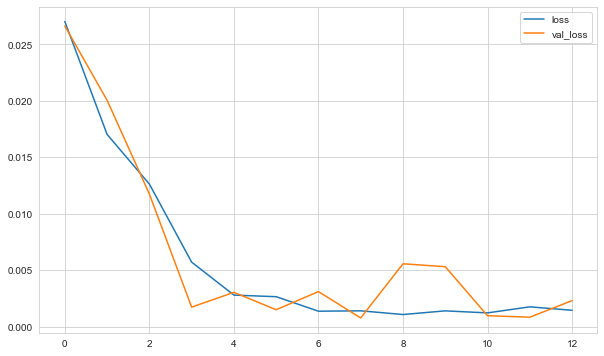

In [34]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

## Evaluate on Test Data

In [35]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [36]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    score = r2_score(actual, pred)
    return print("r2_score:", score, "\nmae:", mae, "\nmse:",mse, "\nrmse:",rmse)

In [37]:
predictions_scaled = []

first_eval_batch = train_scaled[-length:] 
# We take the last 12(length) lines of the train data and make predictions, again we take the last 12 and make predictions
# by continuing like this, we make 12 predictions, that is, we make 1-year predictions
# prediction on prediction corrupts data length up to prediction 1 year(12 months)
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(length):
    
    # get prediction 1 time stamp ahead
    current_pred = model.predict(current_batch) # iki boyutlu
    
    # store prediction
    predictions_scaled.append(current_pred[0]) # içine giriyoruz
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis=1) 
    # Take line 1 and append the predict value to the end

In [38]:
predictions_scaled
# this actually becomes the head of the test data
# because we made 12 forecasts by taking and shifting 12 lines in the train data

[array([0.6373744], dtype=float32),
 array([1.0655695], dtype=float32),
 array([0.3980383], dtype=float32),
 array([0.45441067], dtype=float32),
 array([0.5447371], dtype=float32),
 array([0.54113734], dtype=float32),
 array([0.5661489], dtype=float32),
 array([0.5294007], dtype=float32),
 array([0.5373636], dtype=float32),
 array([0.6003366], dtype=float32),
 array([0.5173097], dtype=float32),
 array([0.5360153], dtype=float32)]

In [39]:
eval_metrics(test_scaled[:length], predictions_scaled)
# (in the test data, we reserved the last 24 lines of all the data, at first)
# we will take the first 12 lines of the test data and compare

r2_score: 0.9224813901622368 
mae: 0.030049148205837605 
mse: 0.001716837631891484 
rmse: 0.04143473943313128


### Inverse Transformations and Comparing

In [40]:
predictions = scaler.inverse_transform(predictions_scaled) # we do reverse scaling to plot

In [41]:
compare = test[:12]

In [42]:
compare['Predictions'] = predictions

In [43]:
compare

,Sales,Predictions
DATE,,
2017-11-01,24438,24493.841
2017-12-01,33720,36288.047
2018-01-01,15881,17901.567
2018-02-01,18585,19454.288
2018-03-01,22404,21942.239
2018-04-01,20616,21843.087
2018-05-01,23764,22532.005
2018-06-01,21589,21519.813
2018-07-01,21919,21739.143


<AxesSubplot:xlabel='DATE'>

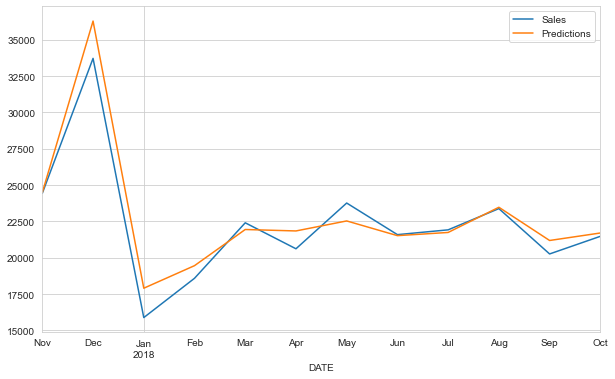

In [44]:
compare.plot()

In [45]:
eval_metrics(compare.Sales, compare.Predictions)

r2_score: 0.922481390162237 
mae: 827.6737381815901 
mse: 1302516.5299847655 
rmse: 1141.2784629461669


## Retrain and Forecasting

In [46]:
# we train all our data
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [47]:
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length = length, batch_size = batch_size)
# we generate data to export from whole model to model

In [48]:
len(df)

334

In [49]:
len(generator)# for length 12

322

In [50]:
# We can't put an early stop because there is no validation data
model = Sequential()
model.add(LSTM(100, activation = 'relu', return_sequences=True, input_shape = (length, n_features)))
model.add(LSTM(50, activation = 'relu'))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

model.fit_generator(generator, epochs=15)

Epoch 1/15
322/322 [==============================] - 3s 6ms/step - loss: 0.0242
Epoch 2/15
322/322 [==============================] - 2s 6ms/step - loss: 0.0197
Epoch 3/15
322/322 [==============================] - 2s 6ms/step - loss: 0.0122
Epoch 4/15
322/322 [==============================] - 2s 7ms/step - loss: 0.0054
Epoch 5/15
322/322 [==============================] - 2s 7ms/step - loss: 0.0053
Epoch 6/15
322/322 [==============================] - 2s 6ms/step - loss: 0.0024
Epoch 7/15
322/322 [==============================] - 2s 7ms/step - loss: 0.0014
Epoch 8/15
322/322 [==============================] - 2s 7ms/step - loss: 0.0015
Epoch 9/15
322/322 [==============================] - 2s 7ms/step - loss: 0.0016
Epoch 10/15
322/322 [==============================] - 2s 6ms/step - loss: 0.0012
Epoch 11/15
322/322 [==============================] - 2s 6ms/step - loss: 0.0015
Epoch 12/15
322/322 [==============================] - 2s 7ms/step - loss: 0.0013
Epoch 13/15
322/322 [====

In [51]:
scaled_full_data.shape

(334, 1)

In [52]:
scaled_full_data[-length:].shape

(12, 1)

In [53]:
forecast = [] 
# we will take 12 data from the end of all our data and get forecasts
# Replace periods with whatever forecast length you want

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(length):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)
    
    # store prediction
    forecast.append(current_pred[0]) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis = 1)

In [54]:
forecast = scaler.inverse_transform(forecast)

In [55]:
forecast

array([[26665.82858706],
       [35566.36296272],
       [17656.36818099],
       [19134.74794078],
       [22677.95627689],
       [22231.88614368],
       [23801.32722759],
       [21843.63024855],
       [22415.28279018],
       [24441.92835808],
       [20677.93169069],
       [22020.09542513]])

In [56]:
df

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


In [57]:
forecast_index = pd.date_range(start = '2019-11-01', periods = length, freq = 'MS') 
# we index the values we predict
# start '2019-11-01', period 12, freq 'MS' ie month

https://stackoverflow.com/questions/35339139/what-values-are-valid-in-pandas-freq-tags

In [58]:
forecast_index

DatetimeIndex(['2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01'],
              dtype='datetime64[ns]', freq='MS')

In [59]:
forecast_df = pd.DataFrame(data = forecast, index = forecast_index, columns = ['Forecast'])

In [60]:
forecast_df

,Forecast
2019-11-01,26665.829
2019-12-01,35566.363
2020-01-01,17656.368
2020-02-01,19134.748
2020-03-01,22677.956
2020-04-01,22231.886
2020-05-01,23801.327
2020-06-01,21843.630
2020-07-01,22415.283
2020-08-01,24441.928


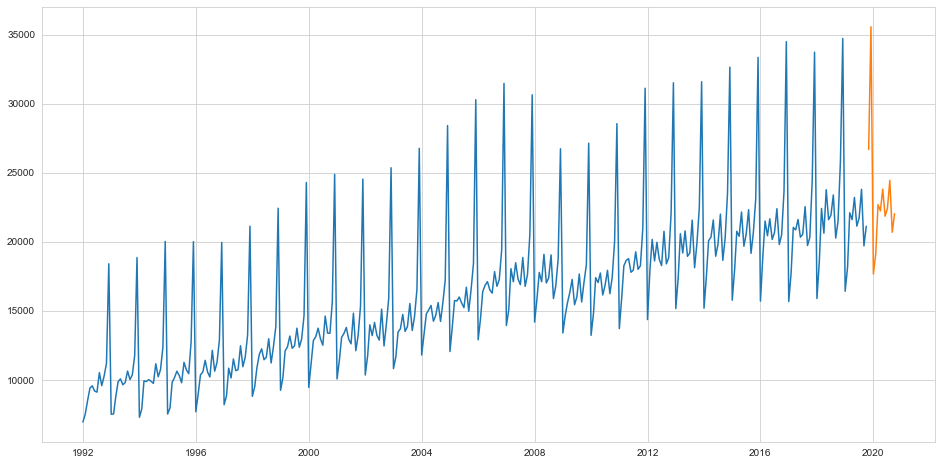

In [61]:
plt.figure(figsize = (16, 8))
plt.plot(df.index, df['Sales'])
plt.plot(forecast_df.index, forecast_df['Forecast'])

### Joining pandas plots

https://stackoverflow.com/questions/13872533/plot-different-dataframes-in-the-same-figure

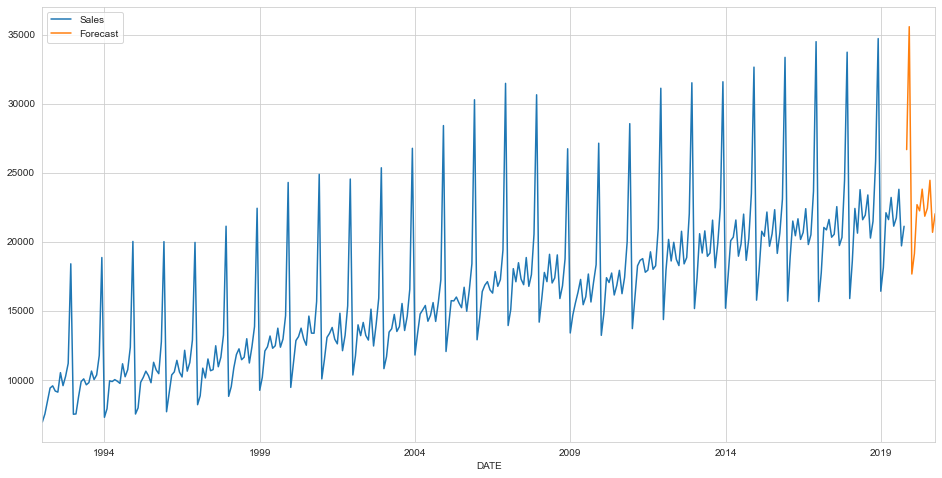

In [62]:
# 2nd way
ax = df.plot() # transfer big data to ax
forecast_df.plot(ax = ax, figsize = (16, 8));

(576.0, 611.0)

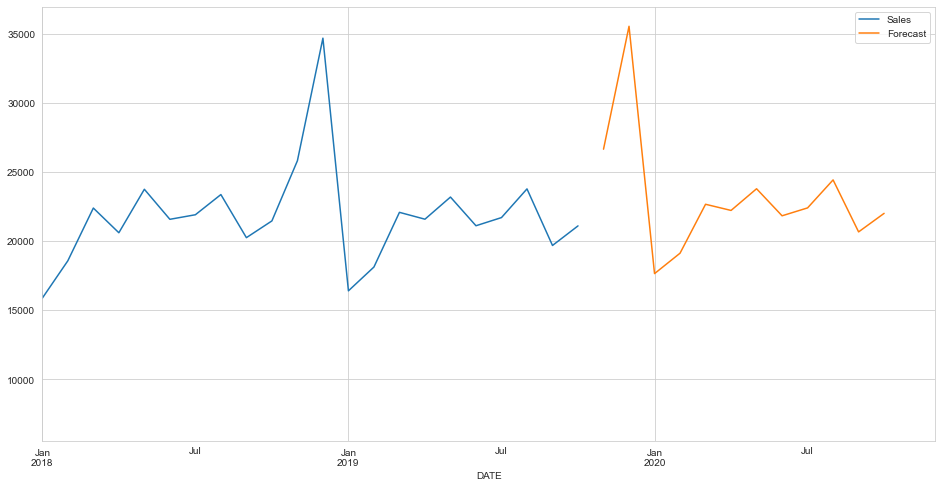

In [63]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (16, 8))
plt.xlim('2018-01-01', '2020-12-01')